In [2]:
#.libPaths(c("/home/data/refdir/Rlib","/home/data/t060324/R/x86_64-pc-linux-gnu-library/4.1"))
library(scibet)
library(Seurat)
library(scater)
library(scran)
library(dplyr)
library(Matrix)
library(cowplot)
library(ggplot2)
library(harmony)
rm(list = ls())
gc()
setwd('/home/data/t060324/jobs/aimin/')

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Attaching SeuratObject

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians

used     (Mb)  gc trigger (Mb)  max used (Mb) 
Ncells  7986527 426.6 14812875   791.1 10346765 552.6
Vcells 13727540 104.8 21468864   163.8 17824054 136.0

## 0.Data integration

In [5]:
OV_GSE165897_immune <- readRDS(file = './output/OV_GSE165897_immune.rds')

In [8]:
OV_GSE184880_immune <- readRDS(file='./output/1.sangleCell_pre/OV_GSE184880_immune.RDS')

In [9]:
OV_GSE154600_immune <- readRDS(file='./output/1.sangleCell_pre/OV_GSE154600_immune.RDS')

In [10]:
OV_GSE191301_immune <- readRDS(file = './output/OV_GSE191301_immune.rds')

In [11]:
OV_GSE165897_immune$dataset <- 'GSE165897'
OV_GSE184880_immune$dataset <- 'GSE184880'
OV_GSE154600_immune$dataset <- 'GSE154600'
OV_GSE191301_immune$dataset <- 'GSE191301'

In [12]:
OV_GSE154600_immune$patient_id <- OV_GSE154600_immune$orig.ident
OV_GSE154600_immune$sample <- OV_GSE154600_immune$orig.ident

In [13]:
DefaultAssay(OV_GSE165897_immune) <- 'RNA'
OV_GSE165897_immune.list <- SplitObject(OV_GSE165897_immune,split.by = 'patient_id')
DefaultAssay(OV_GSE184880_immune) <- 'RNA'
OV_GSE184880_immune.list <- SplitObject(OV_GSE184880_immune,split.by = 'patient_id')
DefaultAssay(OV_GSE154600_immune) <- 'RNA'
OV_GSE154600_immune.list <- SplitObject(OV_GSE154600_immune,split.by = 'patient_id')
DefaultAssay(OV_GSE191301_immune) <- 'RNA'
OV_GSE191301_immune.list <- SplitObject(OV_GSE191301_immune,split.by = 'sample')


In [14]:
mergeData.list <- c(OV_GSE165897_immune.list,OV_GSE184880_immune.list,OV_GSE154600_immune.list,OV_GSE191301_immune.list)
names(mergeData.list)

[1] "EOC443"     "EOC540"     "EOC3"       "EOC87"      "EOC136"    
 [6] "EOC1005"    "EOC153"     "EOC349"     "EOC227"     "EOC372"    
[11] "EOC733"     "GSM5599220" "GSM5599221" "GSM5599222" "GSM5599223"
[16] "GSM5599224" "GSM5599225" "GSM5599226" "GSM5599227" "GSM5599228"
[21] "GSM5599229" "GSM5599230" "GSM5599231" "T59"        "T76"       
[26] "T77"        "T89"        "T90"        "GSM5743307" "GSM5743308"
[31] "GSM5743309" "GSM5743310" "GSM5743311" "GSM5743312"

In [15]:
SeuratPreTreatment <- function(obj=NULL,counts,metadata,QC=FALSE,cluster=TRUE,nCount_cut=500,nFeature_cut=200,log10GenesPerUMI_cut=0.8,mitoRatio_cut=0.2){
    if(is.null(obj)){
        obj <- CreateSeuratObject(counts,meta.data = metadata)
    }
    obj$mitoRatio <- PercentageFeatureSet(object = obj, pattern = "^MT-")
    obj$mitoRatio <- obj@meta.data$mitoRatio / 100
    obj$log10GenesPerUMI <- log10(obj$nFeature_RNA)/log10(obj$nCount_RNA)
    obj$riboRatio <- PercentageFeatureSet(object = obj, pattern = "^RP[SL]")
    obj$riboRatio <- obj@meta.data$mitoRatio / 100
    if(QC){
        filtered_obj <- subset(x = obj, subset= (nCount_RNA >= nCount_cut) & 
                          (nFeature_RNA >= nFeature_cut) & 
                          (log10GenesPerUMI > log10GenesPerUMI_cut) & 
                          (mitoRatio < mitoRatio_cut))
        print(dim(filtered_obj))
        if(cluster){
        filtered_obj <- NormalizeData(filtered_obj, normalization.method = "LogNormalize")
        filtered_obj <- FindVariableFeatures(filtered_obj, selection.method = "vst", nfeatures = 3000)
        filtered_obj <- ScaleData(filtered_obj, vars.to.regress = c('nCount_RNA'))
        filtered_obj <- RunPCA(filtered_obj)
        filtered_obj <- RunUMAP(filtered_obj,reduction = "pca",dims = 1:30,seed.use = 12345)
        filtered_obj <- FindNeighbors(filtered_obj,reduction = 'pca', dims = 1:30, verbose = FALSE)
        filtered_obj <- FindClusters(filtered_obj,resolution = 0.5, verbose = FALSE,random.seed=20210707)
        }

        return(filtered_obj)
    }else{
        if(cluster){
        obj <- NormalizeData(obj, normalization.method = "LogNormalize")
        obj <- FindVariableFeatures(obj, selection.method = "vst", nfeatures = 3000)
        obj <- ScaleData(obj, vars.to.regress = c('nCount_RNA'))
        obj <-  RunPCA(obj)
        obj <- RunUMAP(obj,reduction = "pca",dims = 1:30,seed.use = 12345)
        obj <- FindNeighbors(obj,reduction = 'pca', dims = 1:30, verbose = FALSE)
        obj <- FindClusters(obj,resolution = 0.5, verbose = FALSE,random.seed=20210707)
            }
        return(obj)
    }
    

}

In [16]:
length(mergeData.list)

[1] 34

In [17]:
mergeData.list <- lapply(mergeData.list,FUN = function(x){
    SeuratPreTreatment(obj = x,QC=T,cluster=F)
})


[1] 32847  4605
[1] 32847  3135
[1] 32847  4212
[1] 32847  2006
[1] 32847  2044
[1] 32847  2892
[1] 32847  2399
[1] 32847  2463
[1] 32847  3851
[1] 32847  2451
[1] 32847  3639
[1] 27984   938
[1] 27984   761
[1] 27984  1787
[1] 27984   582
[1] 27984  1270
[1] 27984  4538
[1] 27984   809
[1] 27984  3199
[1] 27984   635
[1] 27984  3813
[1] 27984   938
[1] 27984  2945
[1] 33538  7849
[1] 33538  8093
[1] 33538  3565
[1] 33538  3946
[1] 33538  2680
[1] 27984  3737
[1] 27984  5626
[1] 27984  3848
[1] 27984  2710
[1] 27984  2766
[1] 27984  5150


In [18]:
rm(OV_GSE165897_immune)
rm(OV_GSE165897_immune.list)
rm(OV_GSE184880_immune)
rm(OV_GSE184880_immune.list)
rm(OV_GSE154600_immune)
rm(OV_GSE154600_immune.list)
rm(OV_GSE191301_immune)
rm(OV_GSE191301_immune.list)
gc()

In [20]:
mergeData_immune <- merge(mergeData.list[[1]],mergeData.list[-1])

In [23]:
DefaultAssay(mergeData_immune) <- 'RNA'
mergeData_immune <- NormalizeData(mergeData_immune, normalization.method = "LogNormalize")
mergeData_immune <- FindVariableFeatures(mergeData_immune, selection.method = "vst", nfeatures = 2000)
mergeData_immune <- ScaleData(mergeData_immune,vars.to.regress = c('mitoRatio','nCount_RNA'))
mergeData_immune <- RunPCA(mergeData_immune)


Regressing out mitoRatio, nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  NKG7, GZMA, LTB, PRF1, GZMH, GZMK, TIGIT, KLRB1, XCL2, KLRD1 
	   CRIP1, HOPX, IL7R, GZMB, LINC01871, CD27, FKBP11, GNLY, TRGC2, IFNG 
	   ZNF683, CXCR6, FASLG, BATF, ICOS, TNFRSF18, TRDC, CLIC3, XCL1, CTLA4 
Negative:  CST3, C1QA, CD14, AIF1, C1QC, C1QB, PSAP, FCER1G, MARCKS, TYROBP 
	   FTL, CTSB, MS4A7, FCGR2A, NPC2, GRN, APOE, MS4A6A, FCGRT, HLA-DRA 
	   CD68, SPI1, PLAUR, IER3, APOC1, CYBB, LYZ, RNASE1, TREM2, CTSZ 
PC_ 2 
Positive:  ATP5F1E, IGLC2, IGKC, ACTB, ATP5MG, COL1A1, ATP5MC2, ATP5ME, MYL9, IGHG3 
	   RARRES2, ACTA2, FCGBP, GPR34, OLFML3, COL1A2, C3, ATP5MPL, TAGLN, FOS 
	   ATP5MC3, CALD1, WFDC2, ATP5PF, MEF2C, ATP5PO, CALHM6, ATP5MF, ATP5F1B, TPM2 
Negative:  MT-RNR2, MT-RNR1, SOD2, CXCL8, EREG, SNHG5, LRRC75A-AS1, LINC00936, SLC7A11, TCEB1 
	   TXN, HLA-DRB6, VIMP, CYP1B1, SQRDL, SDC2, FTH1P10, SMOX, SERPINB2, SPHK1 
	   RP11-465B22.3, SEMA6B, C15orf48, FNIP2, SMIM3, USP12, CXCL3

In [24]:
mergeData_immune <- RunHarmony(object = mergeData_immune,group.by.vars = c('patient_id','dataset'))

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony converged after 7 iterations

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [25]:
mergeData_immune <- RunUMAP(mergeData_immune,reduction = "harmony",dims = 1:50,seed.use = 12345)
mergeData_immune <- FindNeighbors(mergeData_immune,reduction = 'harmony', dims = 1:50, verbose = FALSE)
mergeData_immune <- RunTSNE(mergeData_immune,reduction = 'harmony',dims = 1:50,seed.use = 12345)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:52:01 UMAP embedding parameters a = 0.9922 b = 1.112

20:52:01 Read 105882 rows and found 50 numeric columns

20:52:01 Using Annoy for neighbor search, n_neighbors = 30

20:52:01 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:52:20 Writing NN index file to temp file /home/data/t060324/Rtmp/RtmpsvZW7P/file2c7d1931ea9edc

20:52:20 Searching Annoy index using 1 thread, search_k = 3000

20:53:22 Annoy recall = 100%

20:53:25 Commencing smooth kNN distance calibration using 1 thread

20

In [26]:
mergeData_immune <- FindClusters(mergeData_immune,resolution = 1, verbose = FALSE,random.seed=20210707)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



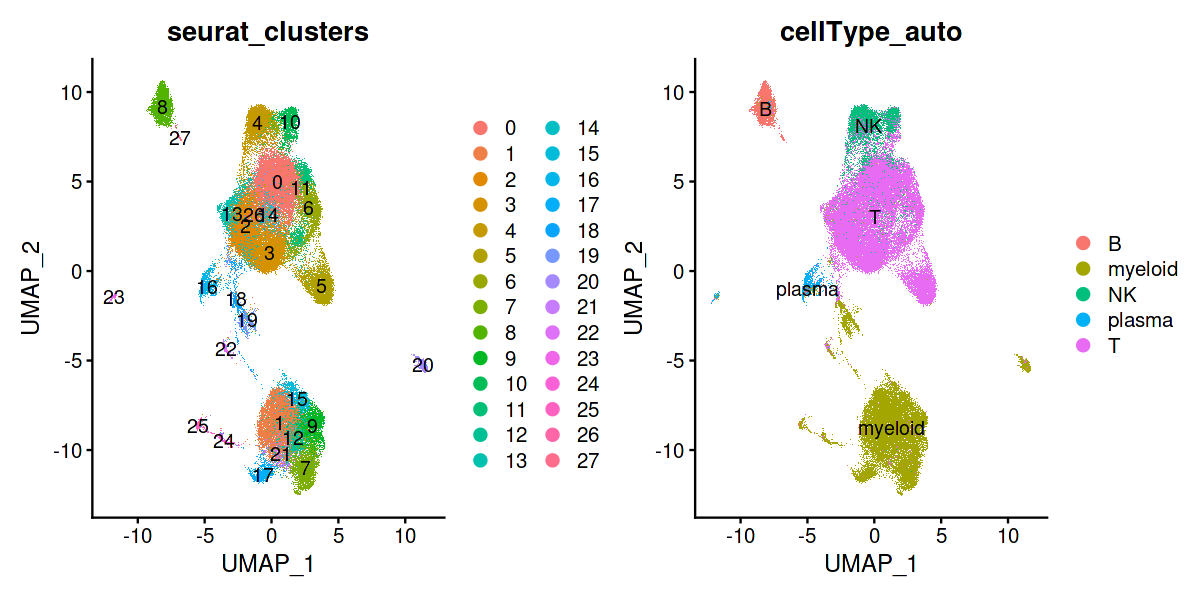

In [27]:
options(repr.plot.height = 5, repr.plot.width = 10)
DimPlot(object = mergeData_immune,reduction = 'umap',group.by = c('seurat_clusters','cellType_auto'),pt.size = 0.3, label = TRUE)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



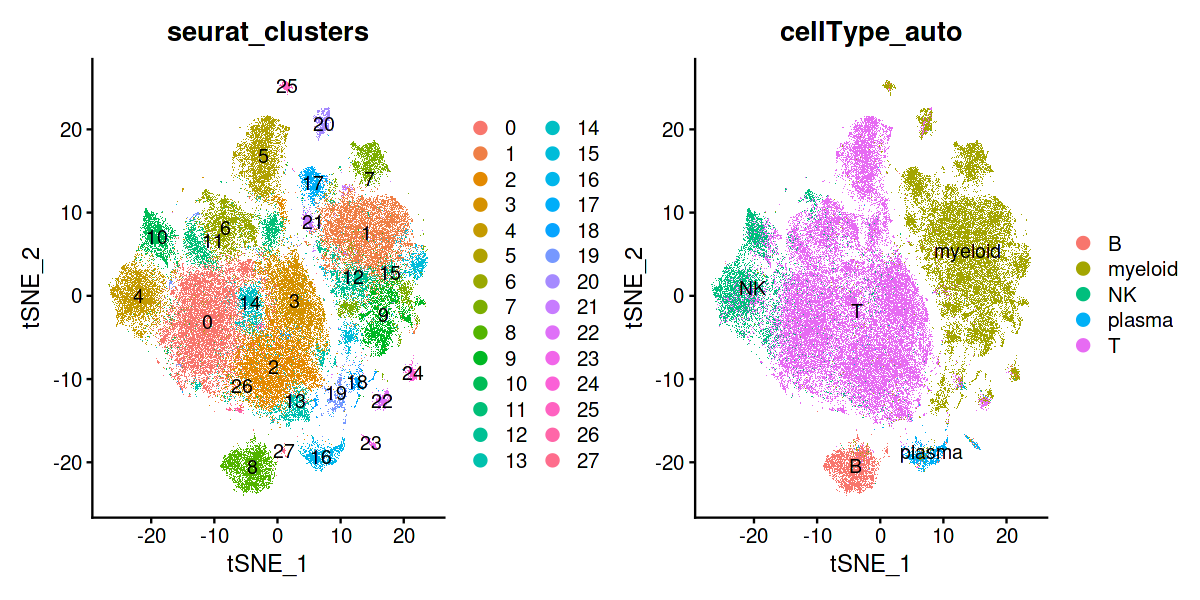

In [28]:
options(repr.plot.height = 5, repr.plot.width = 10)
DimPlot(object = mergeData_immune,reduction = 'tsne',group.by = c('seurat_clusters','cellType_auto'),pt.size = 0.3, label = TRUE)

In [19]:
genes_to_check = c('PTPRC', 'CD3D', 'CD3E','BTLA', 'CD4','CD8A','CXCR6','CD27','CD69','ITGAE','CXCL13','LAG3','GZMA',
                   'GZMK', 'CD79A', 'MS4A1' ,'PDCD1','TIGIT','CTLA4','SLC30A1','IL2RA','FOXP3','IL7R','CCR7',
                   'IGHG1', 'MZB1', 'SDC1',
                   'CD68', 'CD163', 'CD14', 'JCHAIN','TCF4','IRF4',
                   'TPSAB1' , 'TPSB2',  # mast cells,
                   'RCVRN','FPR1' , 'VIM' ,
                   'C1QA',  'C1QB',  # mac
                   'S100A9', 'S100A8','SPP1', 'MMP1','ATF4','THBS1','THBS2','CYR61','CXCL12',# monocyte
                   'LAMP3', 'IDO1','IDO2',## DC3 
                   'CD1E','CD1C', # DC2
                   'KRT86','GNLY', # NK 
                   'FGF7','MME', 'ACTA2','MYH11','TAGLN', ## fibo 
                   'DCN', 'LUM',  'GSN' , ## mouse PDAC fibo 
                   'FAP','FN1','THY1','COL1A1','COL3A1', 
                   'PECAM1', 'VWF',  ## endo 
                   'EPCAM' , 'KRT19', 'KRT18', 'CD24','MKI67' )
                   

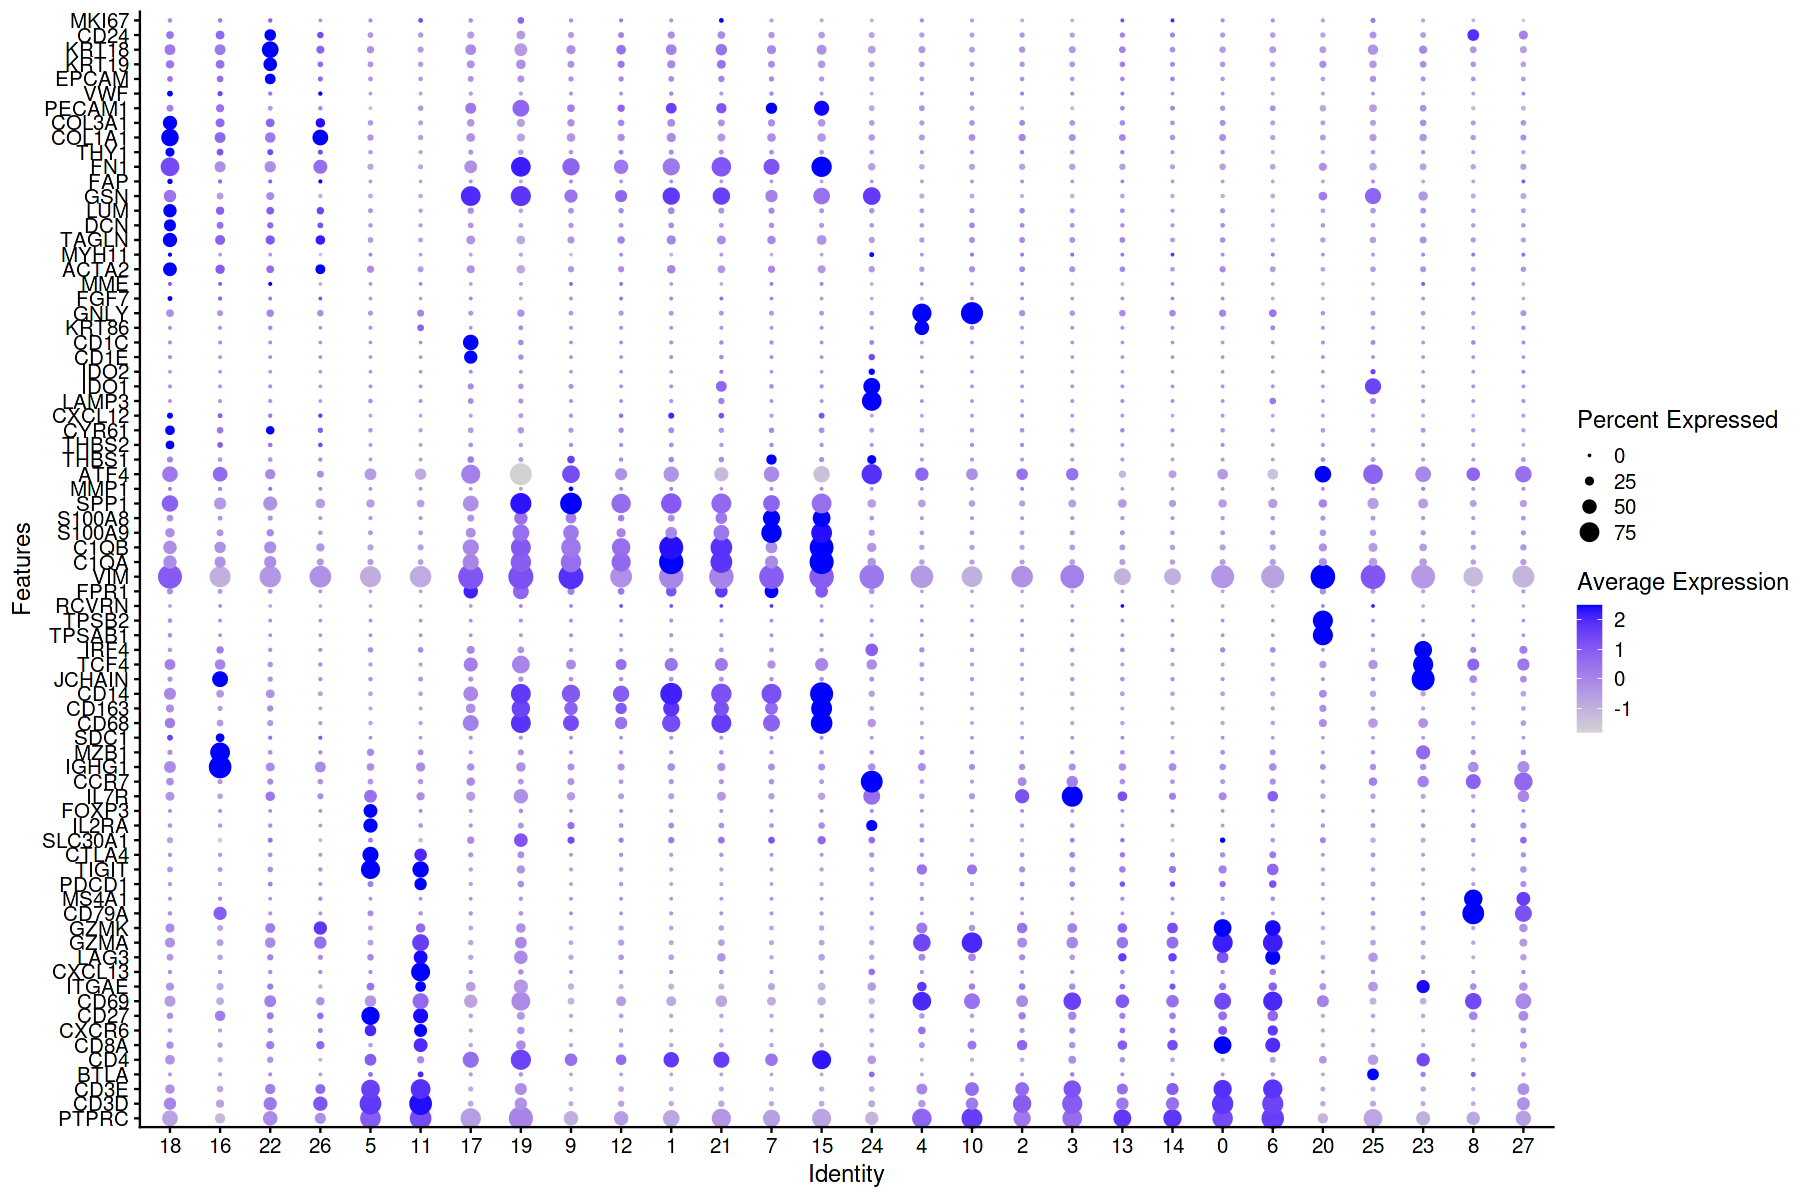

In [35]:
options(repr.plot.height = 10, repr.plot.width = 15)
DotPlot(mergeData_immune,group.by = 'seurat_clusters', features = unique(genes_to_check),assay = 'RNA',cluster.idents = T) + coord_flip()

In [61]:
#mergeData_immune <- subset(mergeData_immune,seurat_clusters%in%c(0:16,18:20,23:28))

In [112]:
cellMarkers <- FindAllMarkers(mergeData_immune,test.use = 'roc',only.pos = T,logfc.threshold = 0.5)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24



In [19]:
saveRDS(cellMarkers,file = './output/1.sangleCell_pre/OV_mergeData_immune_cellMarkers.RDS')

In [3]:
cellMarkers <- readRDS(file = './output/1.sangleCell_pre/OV_mergeData_immune_cellMarkers.RDS')

In [3]:
head(cellMarkers)

myAUC avg_diff  power avg_log2FC pct.1 pct.2 cluster gene
CCL5 0.789 0.9461287 0.578 1.364975   0.929 0.517 0       CCL5
NKG7 0.757 0.7819874 0.514 1.128169   0.810 0.322 0       NKG7
GZMK 0.743 1.2426052 0.486 1.792700   0.642 0.185 0       GZMK
CD8A 0.743 1.0883604 0.486 1.570172   0.628 0.157 0       CD8A
CST7 0.741 0.8955881 0.482 1.292061   0.747 0.345 0       CST7
CD3D 0.737 0.7820971 0.474 1.128328   0.809 0.399 0       CD3D

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



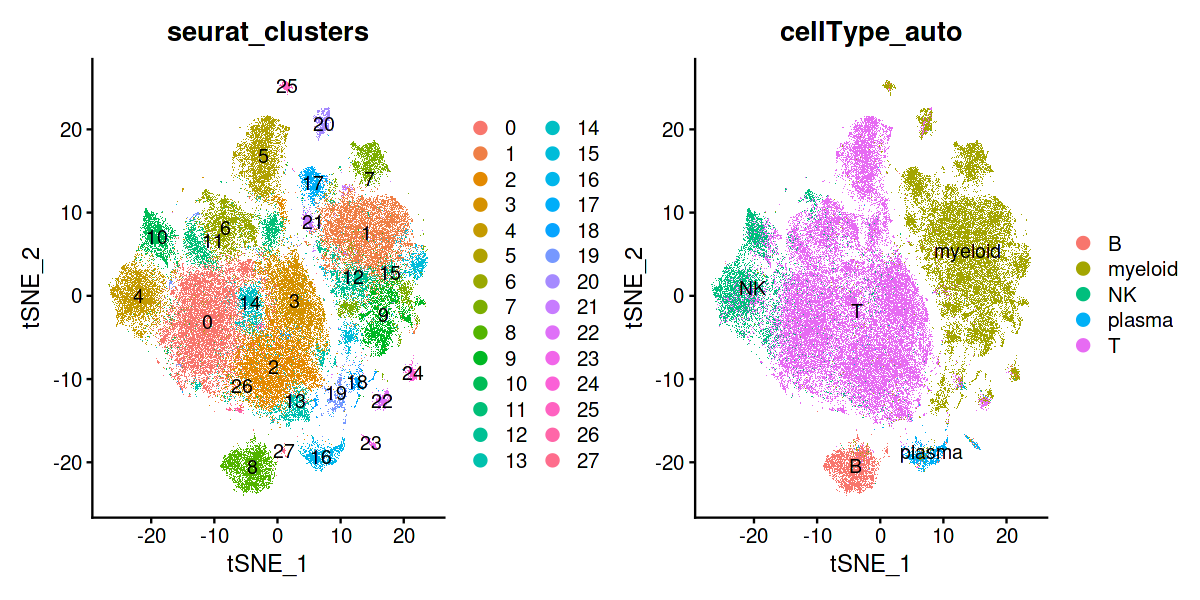

In [33]:
options(repr.plot.height = 5, repr.plot.width = 10)
DimPlot(object = mergeData_immune,reduction = 'tsne',group.by = c('seurat_clusters','cellType_auto'),pt.size = 0.3, label = TRUE)

In [40]:
B_cell=c(8)
IgG_Plasma=c(16)
Plasmablast=c(23)

NK=c(4,10)
pDC=c(25,24)
Treg=c(5)
CD8_Tex =c(11)
ISG_CD8T=c(6)
T_naive =c(2,3,14,13)
GZMK_CD8T=c(0,6)

TAM_C1 = c(1)
TAM_C2 = c(12)
TAM_C3 = c(15)
TAM_C4 = c(7)
TAM_C5 = c(17)
TAM_C6 = c(21)
TAM_C7 = c(9)
cDC2=c(17)
mast_cell =c(20)
unknow=c(22,19,18,26,27)

setdiff(0:27,c(B_cell,IgG_Plasma,Plasmablast,pDC,NK,Treg,CD8_Tex,ISG_CD8T,T_naive,GZMK_CD8T,TAM_C1,TAM_C2,TAM_C3,TAM_C4,TAM_C5,TAM_C6,TAM_C7,cDC2,mast_cell,unknow))

integer(0)

In [42]:
current.cluster.ids <- c(B_cell,
                         IgG_Plasma,
                         Plasmablast,
                         pDC,
                         NK,Treg,CD8_Tex,ISG_CD8T,T_naive,GZMK_CD8T,
                         TAM_C1,TAM_C2,TAM_C3,TAM_C4,TAM_C5,TAM_C6,TAM_C7,
                         cDC2,mast_cell,unknow)

new.cluster.ids <- c(rep("B cell",length(B_cell)),
                     rep("Plasma cell",length(IgG_Plasma)),
                     rep("Plasmablast",length(Plasmablast)),
                     rep("pDC",length(pDC)),
                     rep("NK",length(NK)),
                     rep("Treg",length(Treg)),
                     rep("CD8 Tex",length(CD8_Tex)),
                     rep("ISG+ CD8T",length(ISG_CD8T)),
                     rep("Tn",length(T_naive)),
                     rep("GZMK+ CD8T",length(GZMK_CD8T)),
                     rep("TAM C1",length(TAM_C1)),
                     rep("TAM C2",length(TAM_C2)),
                     rep("TAM C3",length(TAM_C3)),
                     rep("TAM C4",length(TAM_C4)),
                     rep("TAM C5",length(TAM_C5)),
                     rep("TAM C6",length(TAM_C6)),
                     rep("TAM C7",length(TAM_C7)),
                     rep("cDC2",length(cDC2)),
                     rep("mast cell",length(mast_cell)),
                     rep("unknow",length(unknow))
)

mergeData_immune@meta.data$cellType <- plyr::mapvalues(x = mergeData_immune$seurat_clusters, from = current.cluster.ids, to = new.cluster.ids)

The following `from` values were not present in `x`: 6, 17



Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



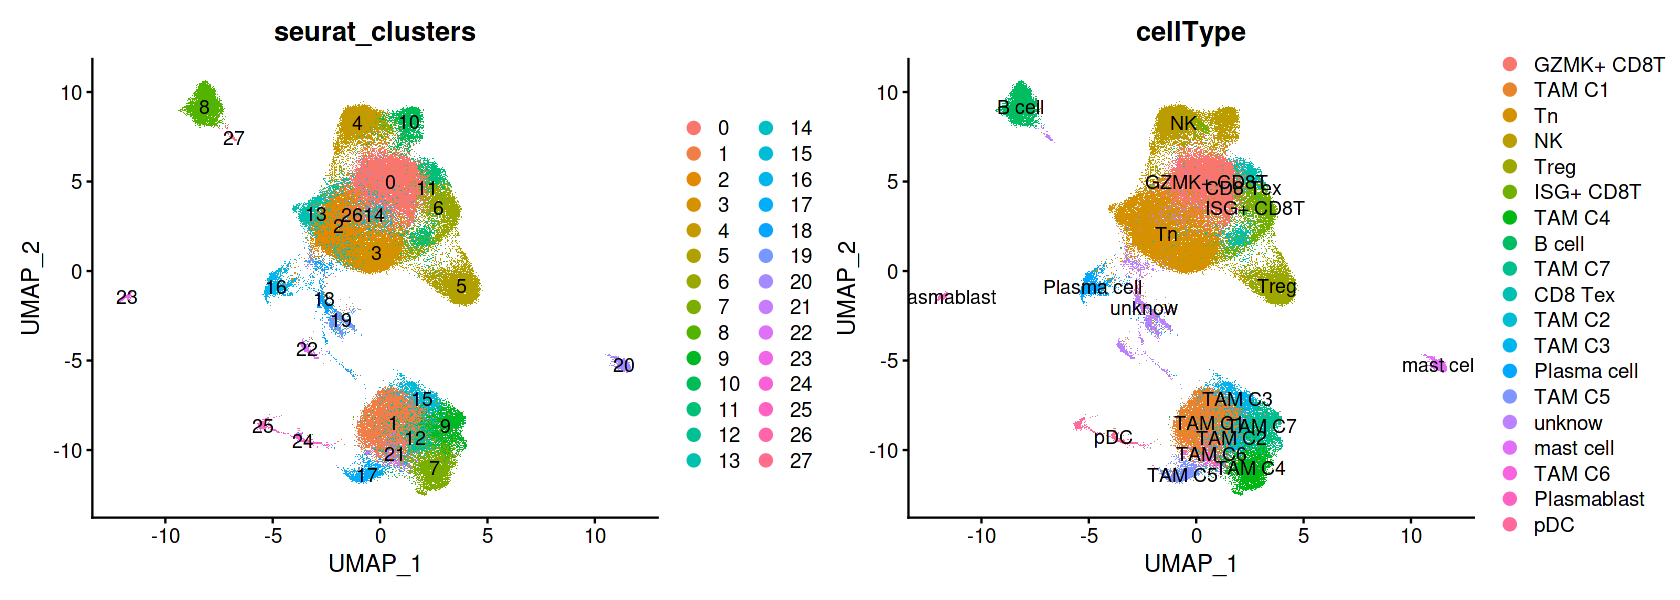

In [43]:
options(repr.plot.height = 5, repr.plot.width = 14)
DimPlot(object = mergeData_immune,reduction = 'umap',group.by = c('seurat_clusters','cellType'),pt.size = 0.3, label = TRUE)

In [44]:
saveRDS(mergeData_immune,file = './output/1.sangleCell_pre/OV_mergeData_immune.RDS')

In [2]:
mergeData_immune <- readRDS(file = './output/1.sangleCell_pre/OV_mergeData_immune.RDS')

In [3]:
mergeData_immune <- subset(mergeData_immune,cellType !='unknow')

In [92]:
mergeData_immune$cellType <- as.character(mergeData_immune$cellType)

## 1.T cell reclustering and cell annotation

In [101]:
mergeData_T <- subset(mergeData_immune,cellType_auto %in% c('NK','T'))

In [102]:
table(mergeData_T$cellType)


 GZMK+ CD8T      TAM C1          Tn          NK        Treg   ISG+ CD8T 
      17028          19       24741        9219        5883        4940 
     TAM C4      B cell      TAM C7     CD8 Tex      TAM C2      TAM C3 
         14          59          18        3138         211          18 
Plasma cell      TAM C5      unknow   mast cell      TAM C6 Plasmablast 
         83           2           0         103           2          19 
        pDC 
         36 

In [111]:
DefaultAssay(mergeData_T) <- 'RNA'
mergeData_T <- NormalizeData(mergeData_T, normalization.method = "LogNormalize")
mergeData_T <- FindVariableFeatures(mergeData_T, selection.method = "vst", nfeatures = 2000)
mergeData_T <- ScaleData(mergeData_T,vars.to.regress = c('mitoRatio','nCount_RNA'))
mergeData_T <- RunPCA(mergeData_T)


Regressing out mitoRatio, nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  MT-ATP6, ACTB, FYB1, GZMA, MYL12A, HCST, PSMB9, JUND, MT-CO1, HLA-DRB1 
	   IL32, HLA-DPA1, CD52, CORO1A, CD81, ISG15, CCL4, HLA-DRA, S100A4, SH3BGRL3 
	   RNF213, CCL5, LY6E, RAC2, RARRES3, CYTOR, SP110, TYMP, HLA-DQA1, JPT1 
Negative:  MT-RNR2, MT-RNR1, GLTSCR2, GAS5, RPS17, SNHG5, LRRC75A-AS1, SNHG6, ZFAS1, C19orf43 
	   SELK, RPL9P9, FTH1, SELT, TCEB2, RP11-425L10.1, C14orf166, SNHG16, WHSC1L1, LINC01578 
	   VIMP, RP11-371A22.1, LINC00152, WBSCR22, TCEB1, SNHG3, HSPA5, PCED1B-AS1, SEP15, LINC-PINT 
PC_ 2 
Positive:  ATP5E, NKG7, KLRD1, CCL5, XCL2, TRDC, GNLY, KLRC1, CTSW, PRF1 
	   XCL1, APOBEC3G, CCL3, CCL4, SAMD3, TYROBP, ID2, ITGA1, MATK, KLRC2 
	   FASLG, GZMA, IKZF3, HOPX, ZNF683, GZMB, GNPTAB, CD81, MT-RNR2, C5orf56 
Negative:  ATP5F1E, ATP5MG, IGKC, ATP5ME, ATP5MC2, COL1A1, ATP5MPL, RARRES2, IGLC2, ATP5MD 
	   FN1, ATP5MF, ATP5IF1, ATP5PF, ATP5F1D, ATP5MC3, COL1A2, ATP5PO, MYL9, TAGLN

In [112]:
mergeData_T <- RunHarmony(object = mergeData_T,group.by.vars = c('patient_id','dataset'))

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [113]:
mergeData_T <- RunUMAP(mergeData_T,reduction = "harmony",dims = 1:30,seed.use = 12345)
mergeData_T <- FindNeighbors(mergeData_T,reduction = 'harmony', dims = 1:30, verbose = FALSE)
mergeData_T <- RunTSNE(mergeData_T,reduction = 'harmony',dims = 1:30,seed.use = 12345)
mergeData_T <- FindClusters(mergeData_T,resolution = 1, verbose = FALSE,random.seed=20210707)

17:12:03 UMAP embedding parameters a = 0.9922 b = 1.112

17:12:03 Read 57702 rows and found 30 numeric columns

17:12:03 Using Annoy for neighbor search, n_neighbors = 30

17:12:03 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:12:12 Writing NN index file to temp file /home/data/t060324/Rtmp/RtmpL4Xg8c/file1f13e0665c8667

17:12:12 Searching Annoy index using 1 thread, search_k = 3000

17:12:40 Annoy recall = 100%

17:12:43 Commencing smooth kNN distance calibration using 1 thread

17:12:49 Initializing from normalized Laplacian + noise

17:12:52 Commencing optimization for 200 epochs, with 2649220 positive edges

17:13:21 Optimization finished



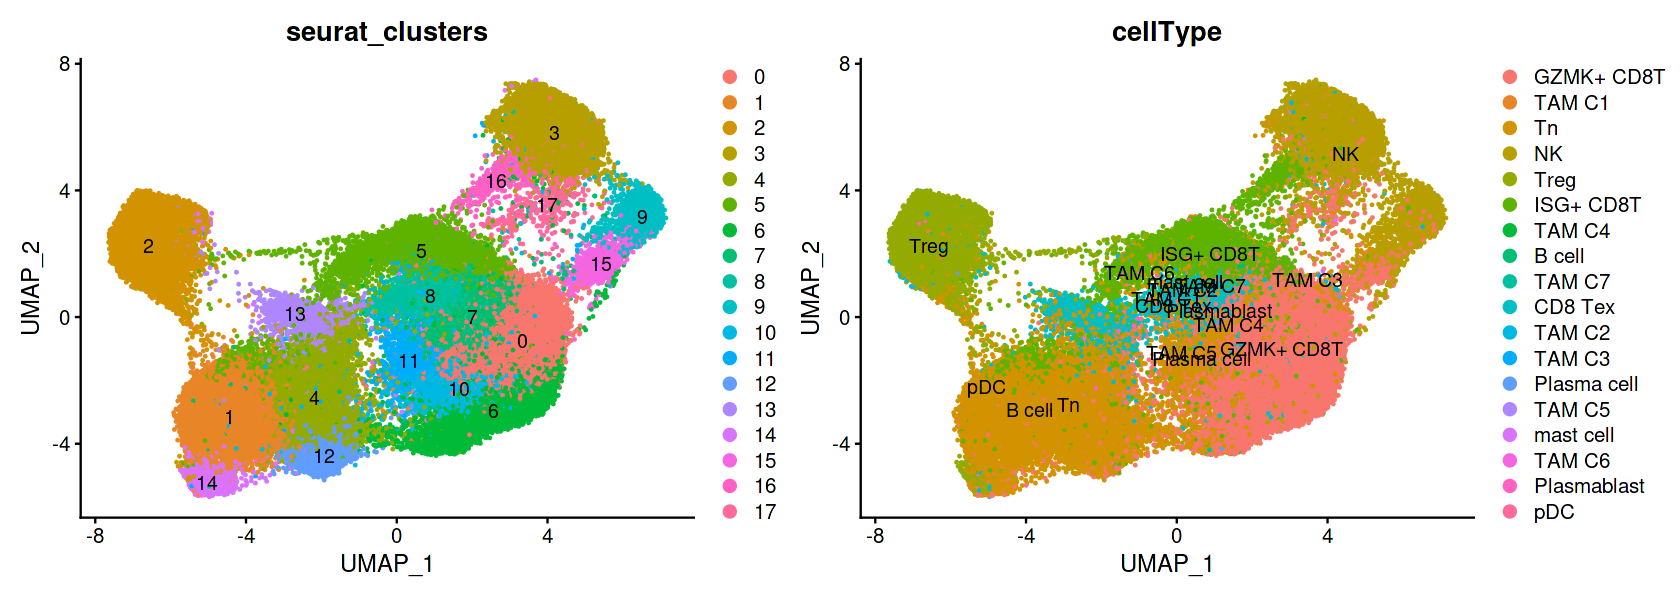

In [114]:
options(repr.plot.height = 5, repr.plot.width = 14)
DimPlot(object = mergeData_T,reduction = 'umap',group.by = c('seurat_clusters','cellType'),pt.size = 0.3, label = TRUE)

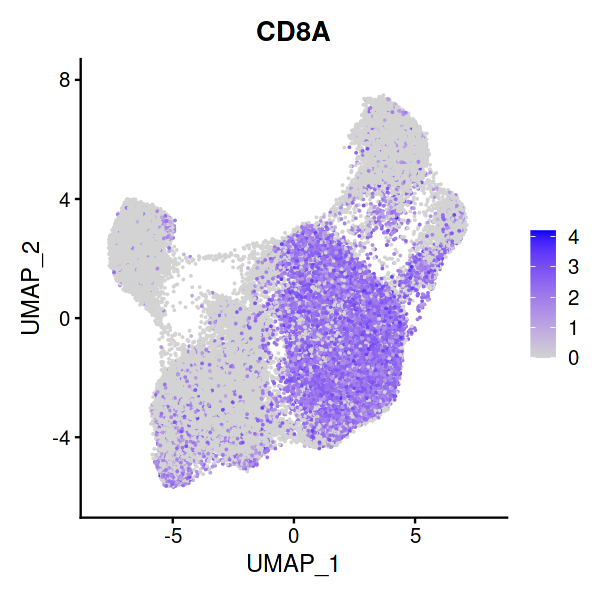

In [115]:
options(repr.plot.height = 5, repr.plot.width = 5)
FeaturePlot(object = mergeData_T,features = 'CD8A',reduction = 'umap')

In [110]:
#mergeData_T <- subset(mergeData_T,seurat_clusters %in% c(0:5,7:9,11:17,19))
#mergeData_T <- subset(mergeData_T,seurat_clusters %in% c(0:5,7:11,13:14,16,18:19))

In [120]:
TcellMarkers <- FindAllMarkers(mergeData_T,only.pos = T,logfc.threshold = 0.8,min.pct = 0.2)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17



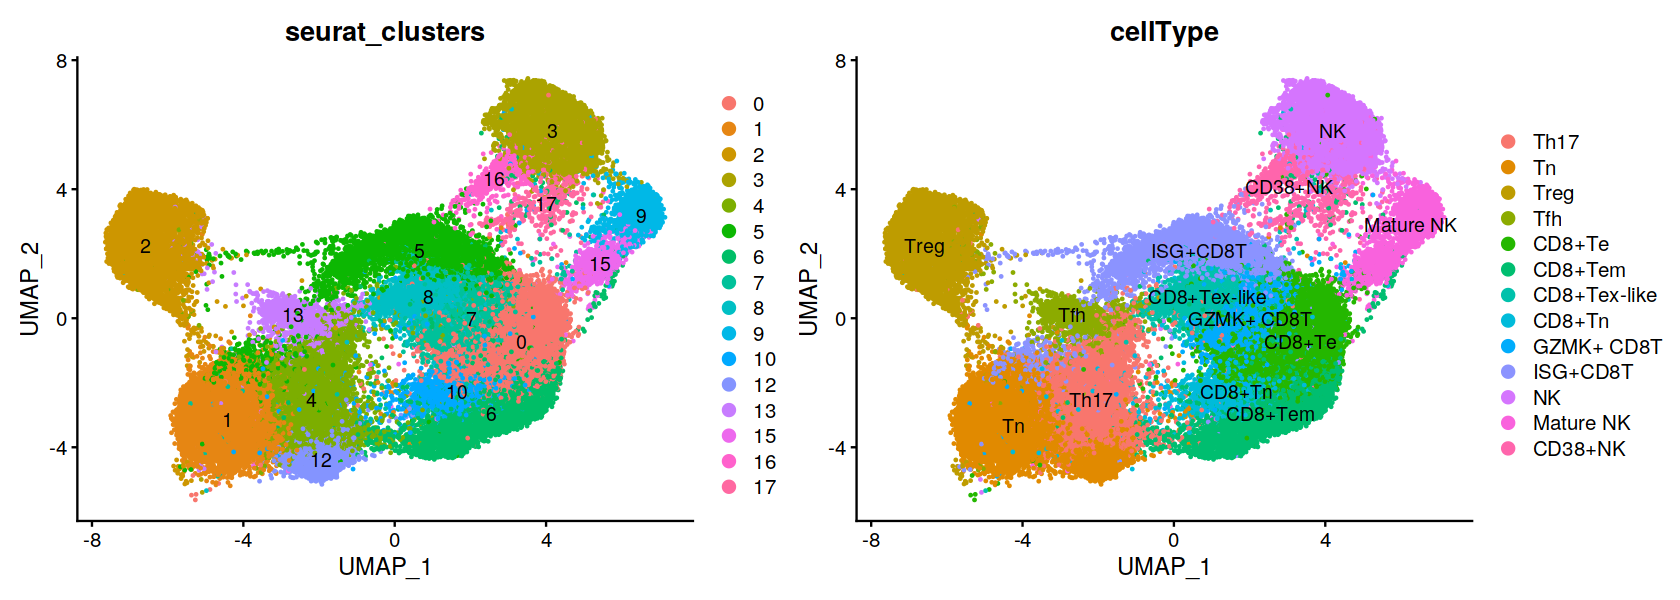

In [4]:
options(repr.plot.height = 5, repr.plot.width = 14)
DimPlot(object = mergeData_T,reduction = 'umap',group.by = c('seurat_clusters','cellType'),pt.size = 0.3, label = TRUE)

In [125]:
NK=c(3)
Mature_NK=c(9,15)
CD38_NK=c(17,16)


Tfh=c(13)
Treg=c(2)
CD8_Tex =c(8)
ISG_CD8_T=c(5)
CD8_Tn = c(10)

#CD8_cytotoxic_Te=c(16)
CD8_Te =c(0)
CD8_Tem=c(6)
CD8_Tpre=c(7)



Tn =c(1,12)
Th17=c(4)


unknow=c(11,14)

setdiff(0:17,c(NK,Mature_NK,CD38_NK,Tfh,Treg,CD8_Tex,CD8_Tem,CD8_Tpre,CD8_Te,CD8_Tn,ISG_CD8_T,Tn,Th17,unknow))

integer(0)

In [126]:
current.cluster.ids <- c(NK,Mature_NK,CD38_NK,Tfh,Treg,CD8_Tex,CD8_Tem,CD8_Tpre,CD8_Te,CD8_Tn,ISG_CD8_T,Tn,Th17,unknow)

new.cluster.ids <- c(rep("NK",length(NK)),
                     rep("Mature NK",length(Mature_NK)),
                     rep("CD38+NK",length(CD38_NK)),
                     rep("Tfh",length(Tfh)),
                     rep("Treg",length(Treg)),
                     rep("CD8+Tex-like",length(CD8_Tex)),
                     rep("CD8+Tem",length(CD8_Tem)),
                     rep("GZMK+CD8T",length(CD8_Tpre)),
                     rep("CD8+Teff",length(CD8_Te)),
                     rep("CD8+Tn",length(CD8_Tn)),
                     rep("ISG+CD8T",length(ISG_CD8_T)),
                     rep("Tn",length(Tn)),
                     rep("Th17",length(Th17)),
                     rep("unknow",length(unknow))
)

mergeData_T@meta.data$cellType <- plyr::mapvalues(x = mergeData_T$seurat_clusters, from = current.cluster.ids, to = new.cluster.ids)

In [127]:
mergeData_T <- subset(mergeData_T,cellType!='unknow')

In [128]:
table(mergeData_T$cellType)


    CD8+Te         Tn       Treg         NK       Th17   ISG+CD8T    CD8+Tem 
      8038       8921       6080       5776       4976       4401       4177 
CD8+TpreEx    CD8+Tex  Mature NK     CD8+Tn     unknow        Tfh    CD38+NK 
      3128       2463       3042       1724          0       1270       1010 

In [129]:
saveRDS(mergeData_T,file = './output/1.sangleCell_pre/OV_mergeData_T.RDS')

In [3]:
mergeData_T <- readRDS(file = './output/1.sangleCell_pre/OV_mergeData_T.RDS')

## 2.Myeloid cell reclustering and cell annotation

In [32]:
table(mergeData_immune$cellType_auto)


      B myeloid      NK  plasma       T 
   4653   29928    8848    2168   56685 

In [33]:
mergeData_TAM <- subset(mergeData_immune,cellType_auto %in% c('myeloid'))

In [46]:
DefaultAssay(mergeData_TAM) <- 'RNA'
mergeData_TAM <- NormalizeData(mergeData_TAM, normalization.method = "LogNormalize")
mergeData_TAM <- FindVariableFeatures(mergeData_TAM, selection.method = "vst", nfeatures = 2000)
mergeData_TAM <- ScaleData(mergeData_TAM,vars.to.regress = c('mitoRatio','nCount_RNA'))
mergeData_TAM <- RunPCA(mergeData_TAM)


Regressing out mitoRatio, nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  FCGR3A, CD68, FOS, CALHM6, CYBB, IFI44L, ZFP36L1, GIMAP4, CD14, IFITM3 
	   CD81, C1QB, SP110, SELENOK, MNDA, C1QA, EPSTI1, XAF1, LY6E, DUSP1 
	   CTSC, TNFSF13B, ATP5F1E, ADA2, STAT1, TREM2, RGS1, GPR34, IFIT1, FPR3 
Negative:  MT-RNR2, MT-RNR1, SNHG5, LRRC75A-AS1, TXN, TCEB2, C19orf43, GLTSCR2, TCEB1, SELK 
	   VIMP, SNHG6, GAS5, ZFAS1, SHFM1, LINC00152, SQRDL, SELT, SOD2, HLA-DRB6 
	   LINC01578, LINC00936, RPL9P9, SMIM3, WTAP, UFD1L, CXCL8, SLC7A11, USP12, RP11-465B22.3 
PC_ 2 
Positive:  CCL3L3, JUN, MARCKS, CCL3, CCL4, HSPA1B, FCGBP, IER5, CCL4L2, HSPA1A 
	   TNF, IER3, C3, USP53, MAF, SGK1, GADD45B, PRDM1, XAF1, BTG2 
	   HTRA1, STAB1, A2M, IER2, DAB2, APOE, NR4A1, SLCO2B1, PLD4, HSP90AA1 
Negative:  ATP5F1E, ATP5MG, ATP5MC2, IGKC, ATP5MPL, ATP5ME, ATP5MD, IGLC2, ATP5MF, ATP5MC3 
	   ATP5F1D, ATP5PO, ATP5PF, ATP5F1B, ATP5F1C, FCN1, ATP5IF1, IGHG3, ATP5PD, ATP5PB 
	   CD52, S100A9, ATP5F1A,

In [47]:
mergeData_TAM <- RunHarmony(object = mergeData_TAM,group.by.vars = c('patient_id','dataset'))



Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [48]:
mergeData_TAM <- RunUMAP(mergeData_TAM,reduction = "harmony",dims = 1:30,seed.use = 12345)
mergeData_TAM <- FindNeighbors(mergeData_TAM,reduction = 'harmony', dims = 1:30, verbose = FALSE)
mergeData_TAM <- RunTSNE(mergeData_TAM,reduction = 'harmony',dims = 1:30,seed.use = 12345)


14:42:49 UMAP embedding parameters a = 0.9922 b = 1.112

14:42:50 Read 24805 rows and found 30 numeric columns

14:42:50 Using Annoy for neighbor search, n_neighbors = 30

14:42:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:42:53 Writing NN index file to temp file /home/data/t060324/Rtmp/RtmpL4Xg8c/file1f13e01319148b

14:42:53 Searching Annoy index using 1 thread, search_k = 3000

14:43:03 Annoy recall = 100%

14:43:05 Commencing smooth kNN distance calibration using 1 thread

14:43:07 Initializing from normalized Laplacian + noise

14:43:08 Commencing optimization for 200 epochs, with 1102162 positive edges

14:43:21 Optimization finished



In [49]:
mergeData_TAM <- FindClusters(mergeData_TAM,resolution = 1, verbose = FALSE,random.seed=20210707)

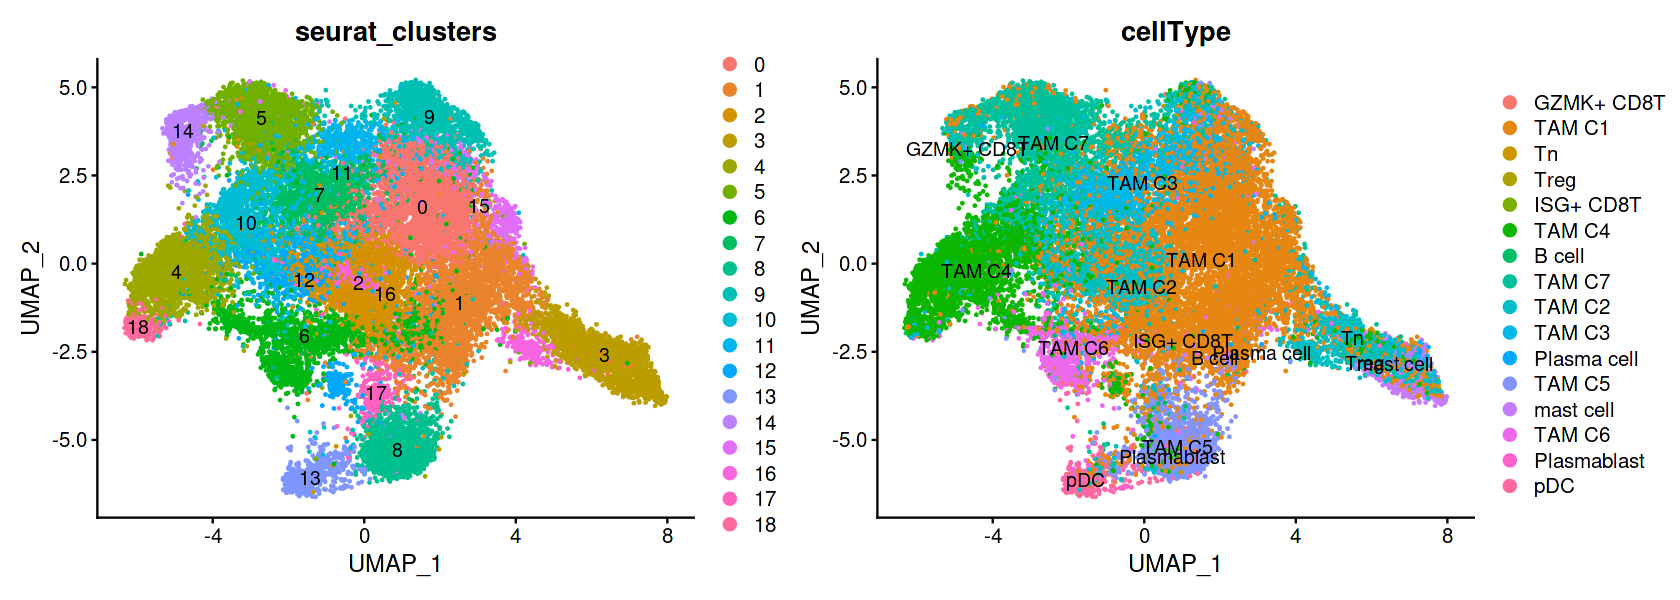

In [50]:
options(repr.plot.height = 5, repr.plot.width = 14)
DimPlot(object = mergeData_TAM,reduction = 'umap',group.by = c('seurat_clusters','cellType'),pt.size = 0.3, label = TRUE)

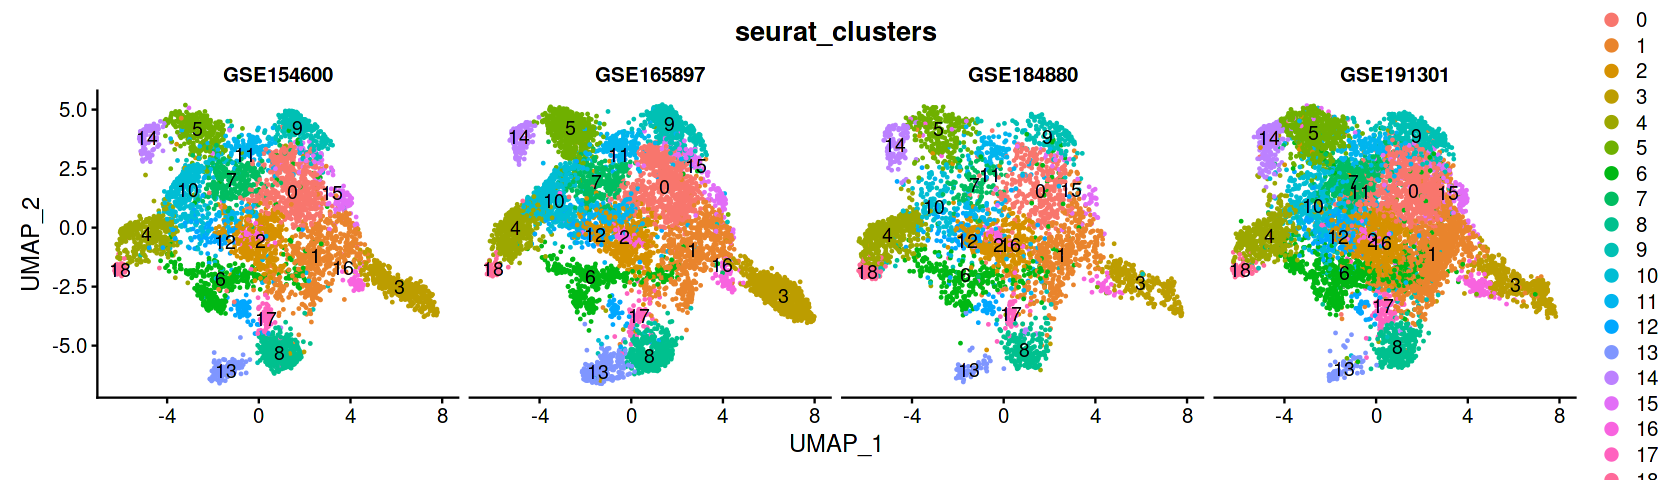

In [51]:
options(repr.plot.height = 4, repr.plot.width = 14)
DimPlot(object = mergeData_TAM,reduction = 'umap',group.by = c('seurat_clusters'),split.by = 'dataset',pt.size = 0.3, label = TRUE)

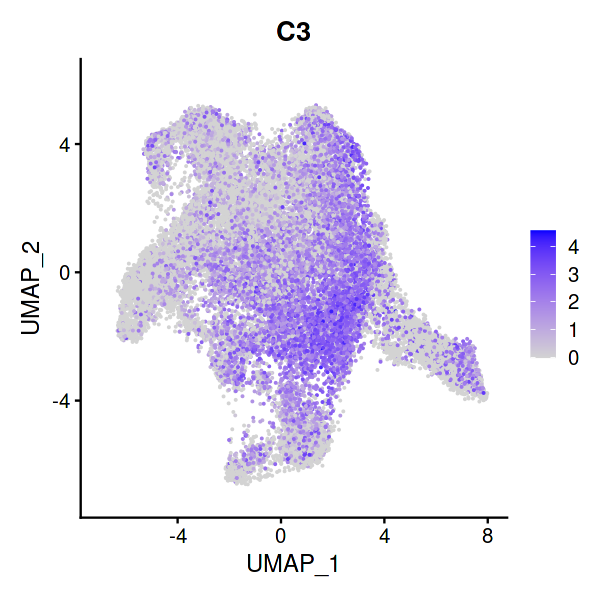

In [85]:
options(repr.plot.height = 5, repr.plot.width = 5)
FeaturePlot(object = mergeData_TAM,features = 'C3',reduction = 'umap')

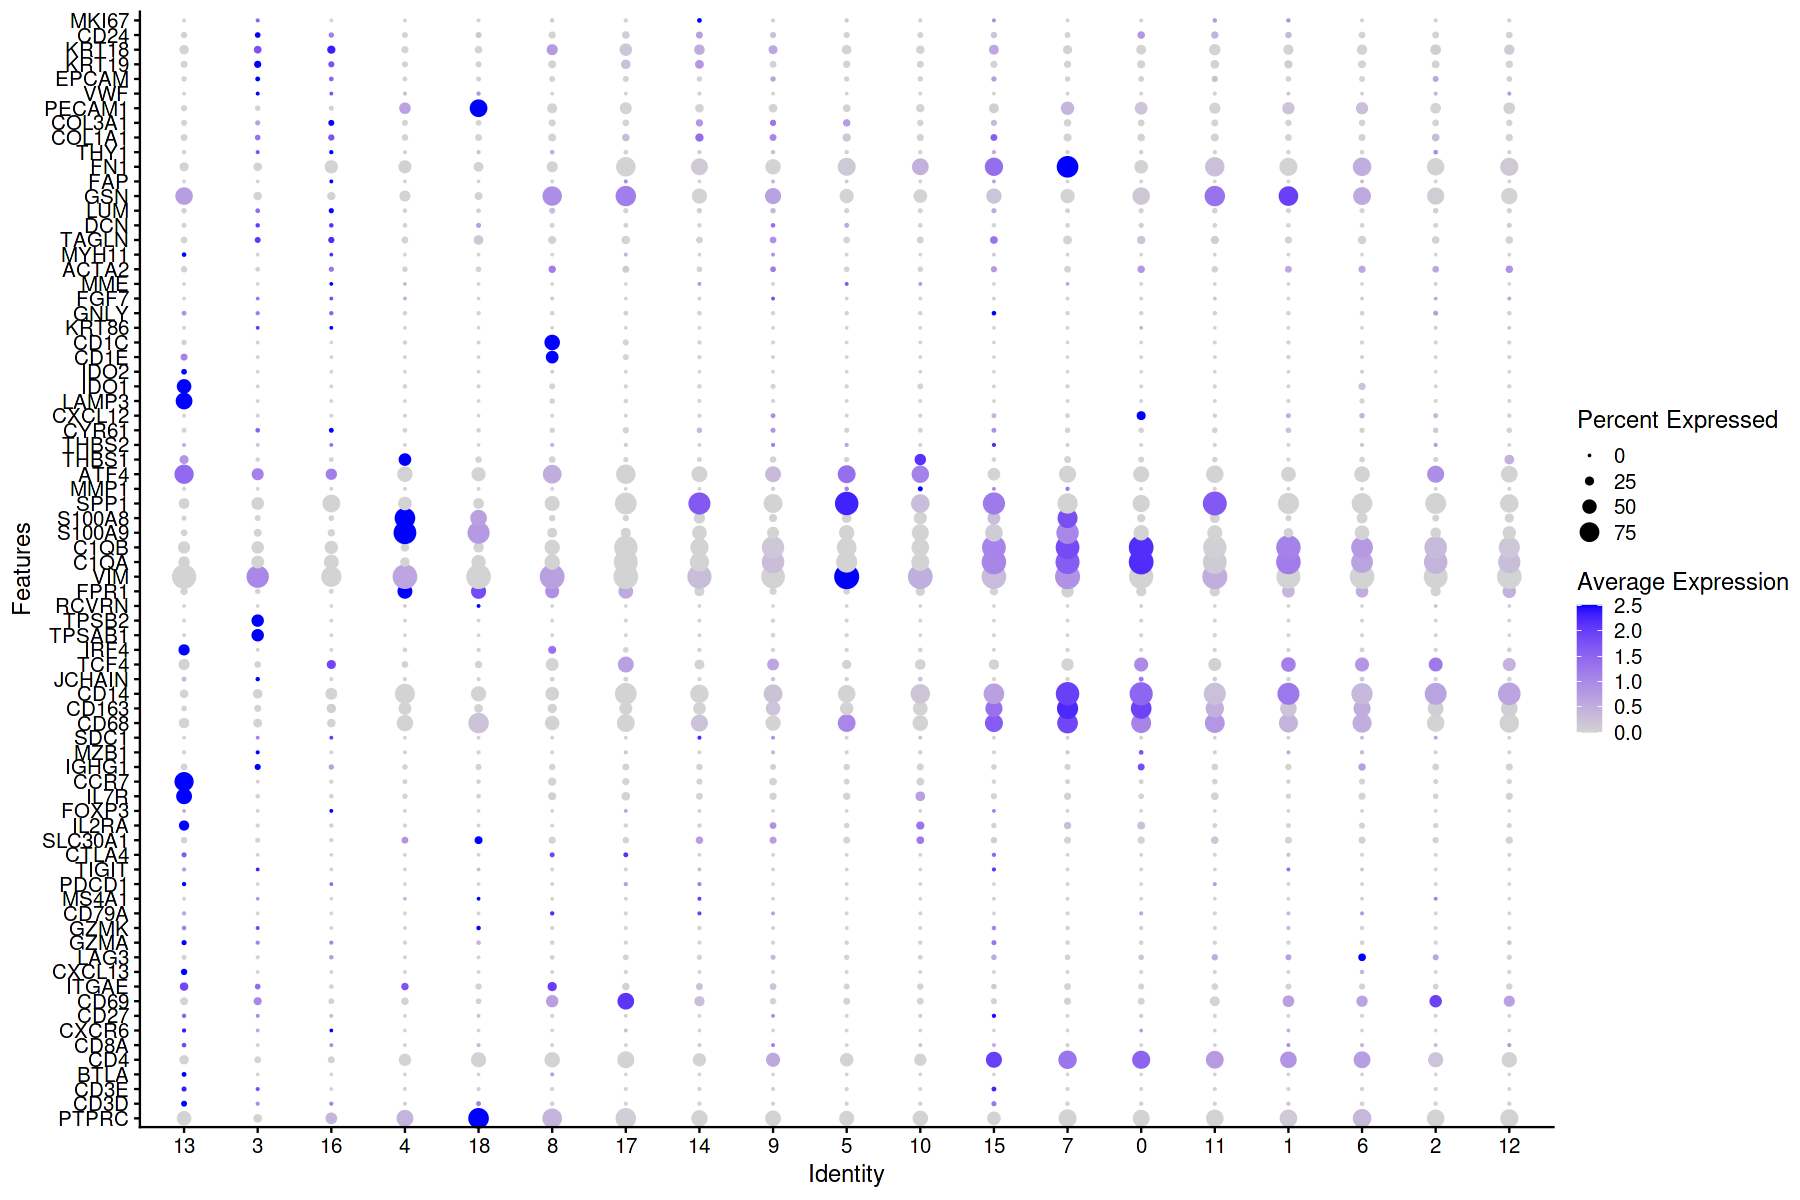

In [52]:
options(repr.plot.height = 10, repr.plot.width = 15)
DotPlot(mergeData_TAM,group.by = 'seurat_clusters', features = unique(genes_to_check),assay = 'RNA',cluster.idents = T,col.min = 0) + coord_flip()

In [45]:
#mergeData_TAM <- subset(mergeData_TAM,seurat_clusters %in% c(0:3,6:18,20,22))

In [94]:
mast_cell = c(3)
cDC2 =c(8)
cDC1=c(13)
Mono_FCN1=c(4,18)
Macro_MARCO=c(7)

Macro_SPP1=c(5,11)
Macro_CCL3L3=c(2,12,17,16)
Macro_CXCL10=c(6)
Macro_C1QB=c(0,1,9,15)
Macro_MT1H=c(10)
unknow=c(14)

setdiff(0:18,c(mast_cell,cDC2,cDC1,Mono_FCN1,Macro_MARCO,Macro_SPP1,Macro_C1QB,Macro_CXCL10,Macro_CCL3L3,Macro_MT1H,unknow))

integer(0)

In [96]:
current.cluster.ids <- c(mast_cell,cDC2,cDC1,Mono_FCN1,Macro_MARCO,Macro_SPP1,Macro_C1QB,Macro_CXCL10,Macro_CCL3L3,Macro_MT1H,unknow)

new.cluster.ids <- c(rep("mast_cell",length(mast_cell)),
                     rep("cDC2",length(cDC2)),
                     rep("cDC1",length(cDC1)),
                     rep("Mono_FCN1",length(Mono_FCN1)),
                     rep("Macro_MARCO",length(Macro_MARCO)),
                     rep("Macro_SPP1",length(Macro_SPP1)),
                     rep("Macro_C1QB",length(Macro_C1QB)),
                     rep("Macro_CXCL10",length(Macro_CXCL10)),
                     rep("Macro_CCL3L3",length(Macro_CCL3L3)),
                     rep("Macro_MT1H",length(Macro_MT1H)),
                     rep("unknow",length(unknow))
)

mergeData_TAM@meta.data$cellType <- plyr::mapvalues(x = mergeData_TAM$seurat_clusters, from = current.cluster.ids, to = new.cluster.ids)

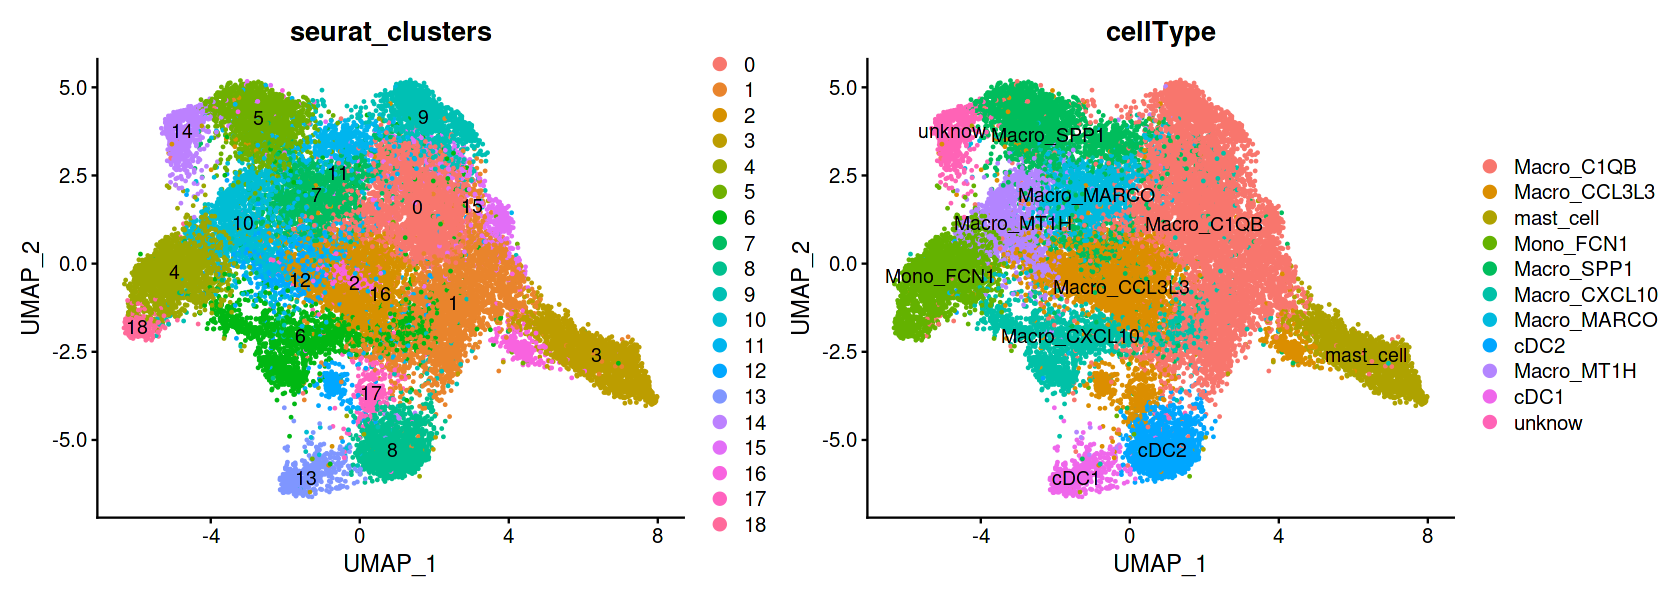

In [97]:
options(repr.plot.height = 5, repr.plot.width = 14)
DimPlot(object = mergeData_TAM,reduction = 'umap',group.by = c('seurat_clusters','cellType'),pt.size = 0.3, label = TRUE)

In [99]:
TAMcellMarkers <- FindAllMarkers(mergeData_TAM,only.pos = T,logfc.threshold = 0.8,min.pct = 0.2)

Calculating cluster 0



In [100]:
saveRDS(mergeData_TAM,file = './output/1.sangleCell_pre/OV_mergeData_TAM.RDS')

In [5]:
mergeData_TAM <- readRDS(file = './output/1.sangleCell_pre/OV_mergeData_TAM.RDS')

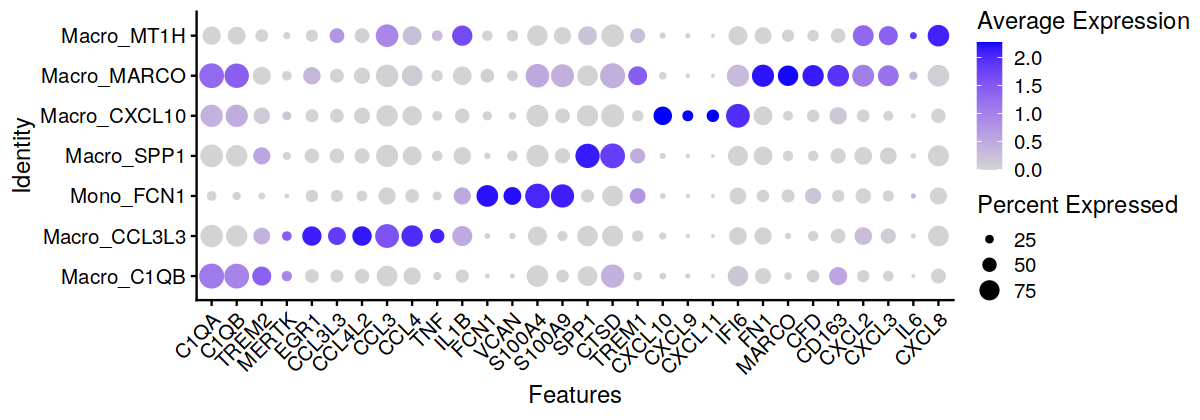

In [16]:
options(repr.plot.height = 3.5, repr.plot.width = 10)
dotplot <- DotPlot(subset(mergeData_TAM,cellType %in% c('Macro_C1QB','Macro_CCL3L3','Macro_CXCL10','Macro_MT1H','Macro_MARCO','Macro_SPP1','Mono_FCN1')),
                   group.by = 'cellType', 
                   features = c('C1QA','C1QB','TREM2','MERTK','EGR1','CCL3L3','CCL4L2','CCL3','CCL4','TNF','IL1B','FCN1','VCAN','S100A4','S100A9','SPP1','CTSD','TREM1','CXCL10','CXCL9','CXCL11','IFI6','FN1','MARCO','CFD','CD163','CXCL2','CXCL3','IL6','CXCL8'),assay = 'RNA',cluster.idents = F,col.min = 0) + theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
dotplot

In [18]:
pdf(file = './output/bulk/section_5/0.TAM_Marker_dotpot.pdf',width = 10,height = 4)
print(dotplot)
dev.off()

png 
  2

## 3.B cell reclustering and cell annotation

In [182]:
mergeData_B <- subset(mergeData_immune,cellType %in% c('Plasma cell','Plasmablast','B cell'))

In [201]:
DefaultAssay(mergeData_B) <- 'RNA'
mergeData_B <- NormalizeData(mergeData_B, normalization.method = "LogNormalize")
mergeData_B <- FindVariableFeatures(mergeData_B, selection.method = "vst", nfeatures = 1000)
mergeData_B <- ScaleData(mergeData_B,vars.to.regress = c('mitoRatio','nCount_RNA'))
mergeData_B <- RunPCA(mergeData_B)


Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -3.4213”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  1.5007e-15”
Regressing out mitoRatio, nCount_RNA

Centering and scaling data matrix

PC_ 1 
Positive:  IGHG1, MT-RNR2, MS4A1, CD27, FKBP11, IGHA1, IGHG3, CTC-575D19.1, KLF2, IGHG2 
	   JSRP1, IGHG4, ID3, SQSTM1, IGLC3, FAM46C, AL928768.3, PRDX4, JUN, IGLL5 
	   SELM, CCR7, IGLC2, BHLHE41, SELK, SDC1, AC079767.4, PDK1, ZBP1, CD69 
Negative:  GZMB, LILRA4, IL3RA, CLIC3, SERPINF1, SMPD3, CD4, PLD4, CLEC4C, LILRB4 
	   LRRC26, MPEG1, MAP1A, TYROBP, ALOX5AP, DNASE1L3, PLAC8, JAML, IRF7, SCT 
	   PTCRA, CTSC, C12orf75, MS4A6A, SLC15A4, SMIM5, CST3, TSPAN13, ZFAT, PTPRE 
PC_ 2 
Positive:  MT-RNR2, MS4A1, CCR7, CD69, LTB, IRF8, KLF2, PMAI

In [202]:
mergeData_B <- RunHarmony(object = mergeData_B,group.by.vars = c('patient_id','dataset'))


Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [203]:
mergeData_B <- RunUMAP(mergeData_B,reduction = "harmony",dims = 1:10,seed.use = 12345)
mergeData_B <- FindNeighbors(mergeData_B,reduction = 'harmony', dims = 1:10, verbose = FALSE)
mergeData_B <- RunTSNE(mergeData_B,reduction = 'harmony',dims = 1:10,seed.use = 12345)


19:04:00 UMAP embedding parameters a = 0.9922 b = 1.112

19:04:00 Read 5276 rows and found 10 numeric columns

19:04:00 Using Annoy for neighbor search, n_neighbors = 30

19:04:00 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:04:01 Writing NN index file to temp file /home/data/t060324/Rtmp/RtmpL4Xg8c/file1f13e054ad7a56

19:04:01 Searching Annoy index using 1 thread, search_k = 3000

19:04:02 Annoy recall = 100%

19:04:04 Commencing smooth kNN distance calibration using 1 thread

19:04:06 Initializing from normalized Laplacian + noise

19:04:07 Commencing optimization for 500 epochs, with 219138 positive edges

19:04:14 Optimization finished



In [204]:
mergeData_B <- FindClusters(mergeData_B,resolution = 0.5, verbose = FALSE,random.seed=20210707)

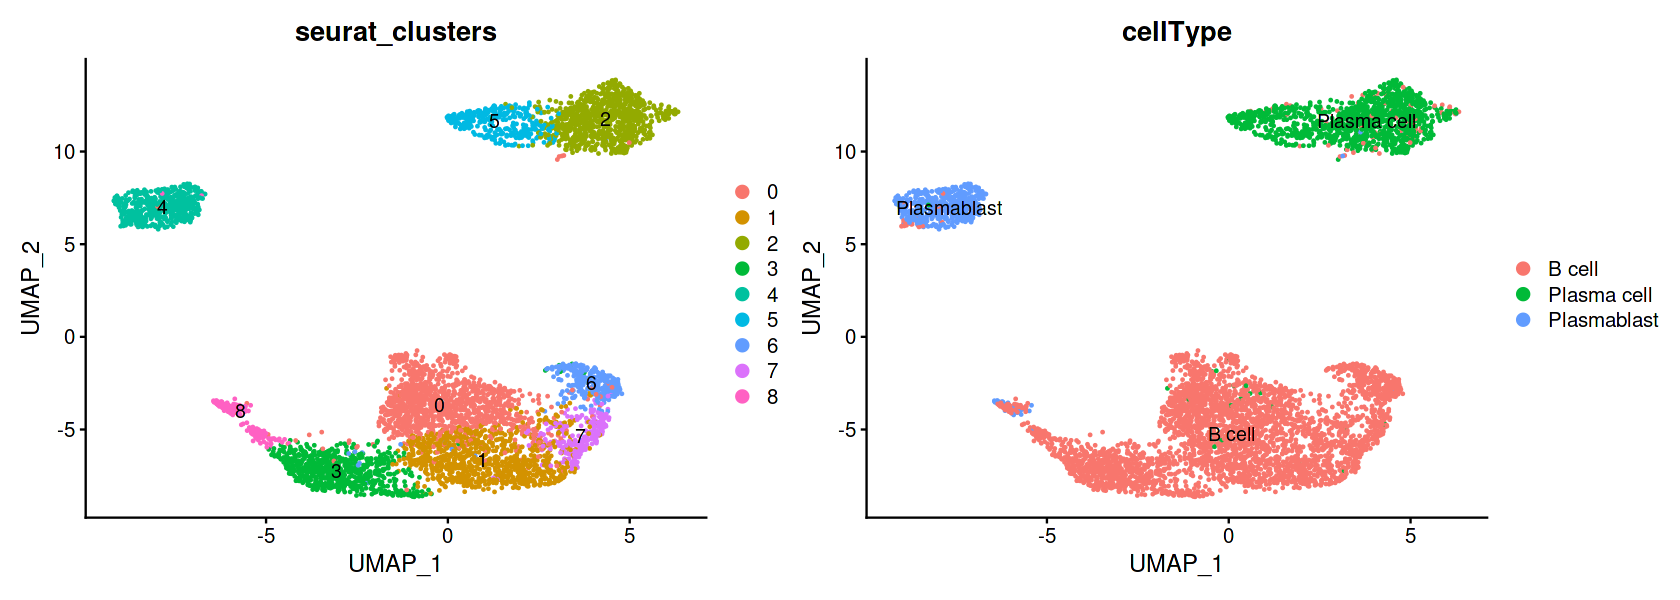

In [205]:
options(repr.plot.height = 5, repr.plot.width = 14)
DimPlot(object = mergeData_B,reduction = 'umap',group.by = c('seurat_clusters','cellType'),pt.size = 0.3, label = TRUE)

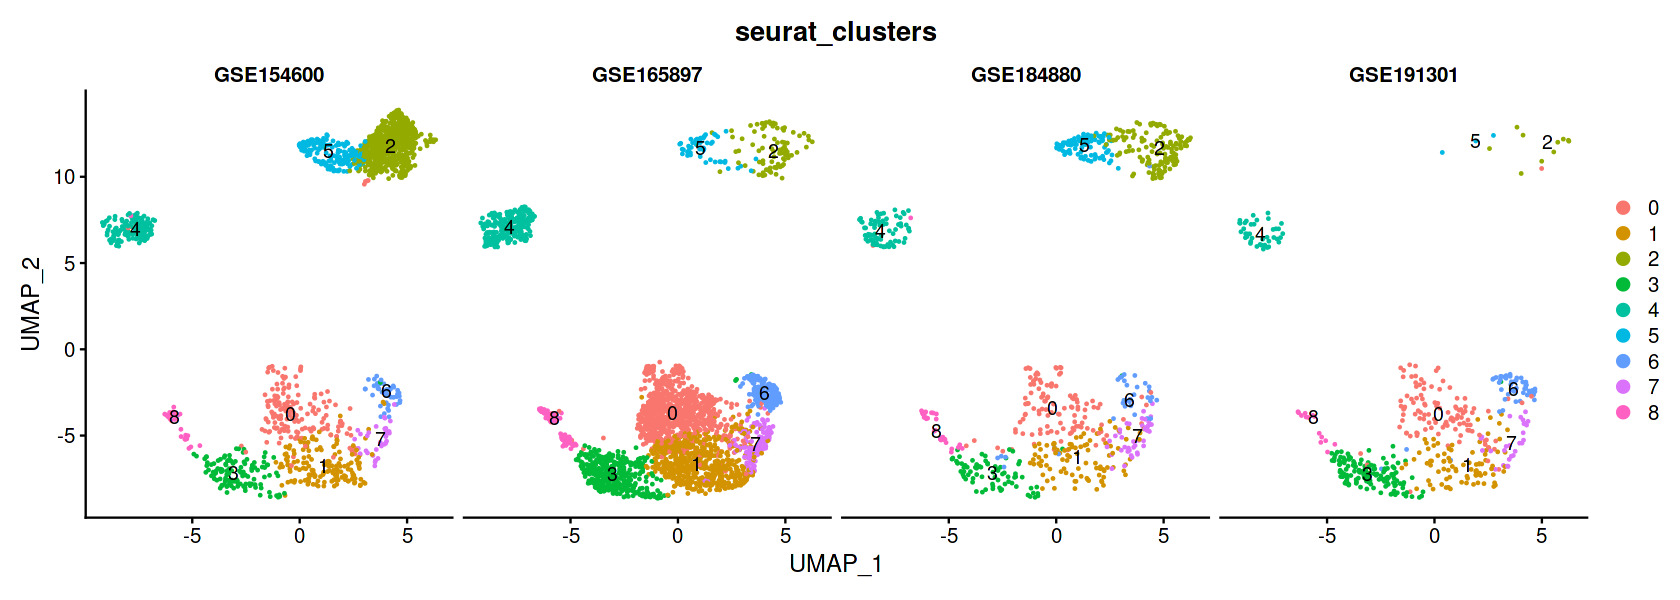

In [206]:
options(repr.plot.height = 5, repr.plot.width = 14)
DimPlot(object = mergeData_B,reduction = 'umap',group.by = c('seurat_clusters'),split.by = 'dataset',pt.size = 0.3, label = TRUE)

In [200]:
mergeData_B <- subset(mergeData_B,seurat_clusters%in%c(0:8,10,11))

In [216]:
B <- c(0,1,3,6,7,8)
Plasma <- c(2,5)
pDC <- c(4)



In [217]:
current.cluster.ids <- c(B,Plasma,pDC)

new.cluster.ids <- c(rep("B cell",length(B)),
                     rep("Plasma cell",length(Plasma)),
                     rep("pDC",length(pDC))
)

mergeData_B@meta.data$cellType <- plyr::mapvalues(x = mergeData_B$seurat_clusters, from = current.cluster.ids, to = new.cluster.ids)

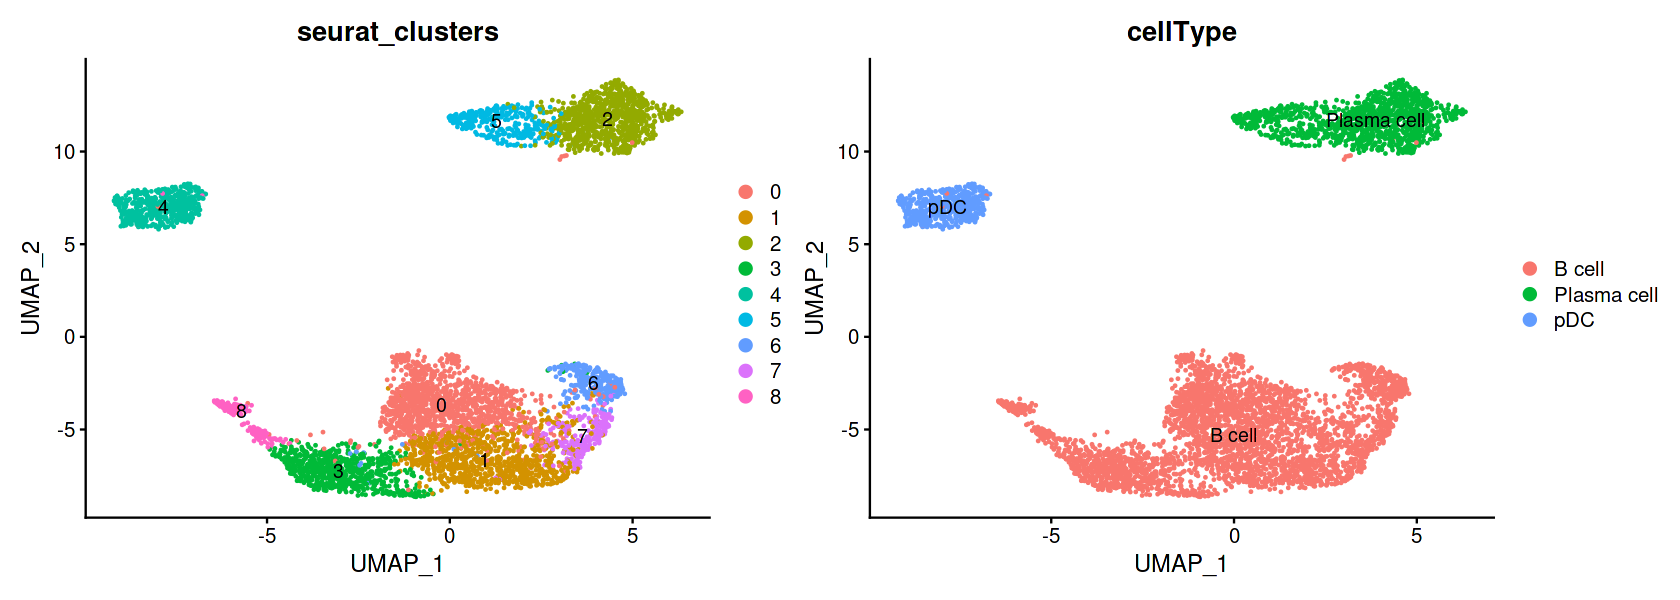

In [218]:
options(repr.plot.height = 5, repr.plot.width = 14)
DimPlot(object = mergeData_B,reduction = 'umap',group.by = c('seurat_clusters','cellType'),pt.size = 0.3, label = TRUE)

In [222]:
saveRDS(mergeData_B,file = './output/1.sangleCell_pre/OV_mergeData_B.RDS')